In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 1. Data

In [7]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("이미지 갯수 : {}".format(image_count))

이미지 갯수 : 3670


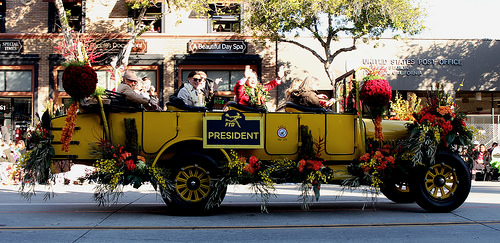

In [10]:
# Desc. Rose 
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [201]:
# 1. Data Import
batch_size = 32
img_height = 180
img_width = 180

print("train dataset import----")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("\ntest dataset import----")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train dataset import----
Found 3670 files belonging to 5 classes.
Using 2936 files for training.

test dataset import----
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [202]:
# 2. train dataset analysis
X_train, y_train = next(iter(train_ds))

batch_size, height, width, color_channel = X_train.shape
print("batch_size : {}".format(batch_size))
print("size information : {} X {}, color channel : {} (RGB Channel)".format(width, height, color_channel))

batch_size : 32
size information : 180 X 180, color channel : 3 (RGB Channel)


RGB Channel Shape : (180, 180, 3)
Grayscale Channel Shape : (180, 180)


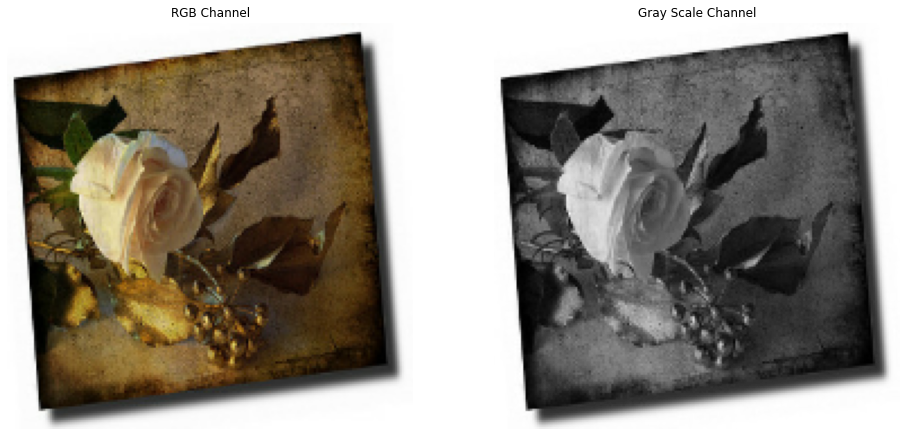

In [203]:
# 3. visualization
plt.figure(figsize=(16, 8))

# RGB Channel
image = np.array(X_train[0])
print("RGB Channel Shape : {}".format(image.shape))
rgb_ax = plt.subplot(1, 2, 1)
plt.title("RGB Channel")
plt.axis("off")
rgb_ax.imshow(image.astype("uint8"))

# Grayscale Channel
R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
imgGray = 0.299 * R + 0.587 * G + 0.114 * B
print("Grayscale Channel Shape : {}".format(imgGray.shape))
gray_ax = plt.subplot(1, 2, 2)
plt.title("Gray Scale Channel")
plt.axis("off")
gray_ax.imshow(imgGray, cmap="gray")

plt.show()

classification label title : daisy dandelion roses sunflowers tulips


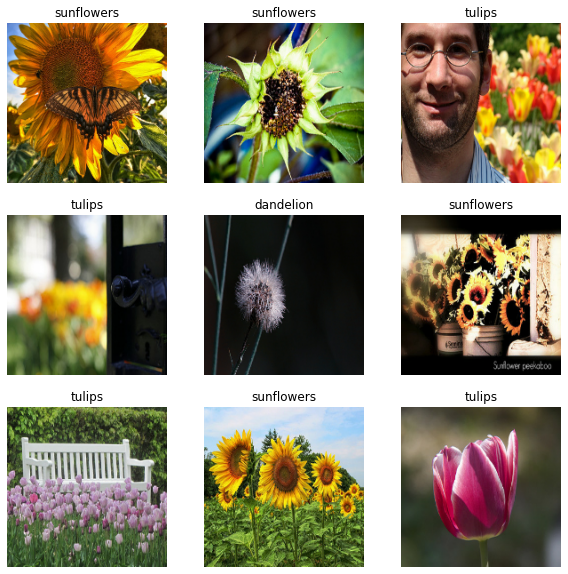

In [204]:
# 4. All datas visualization
class_names = train_ds.class_names
print("classification label title : {}".format(" ".join(class_names)))

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 2. Data Preprocessing

In [205]:
# 1. Options
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [207]:
# 2. scaling, data normalization
# 색의 최댓값은 항상 255를 가진다.
# 해당 레이어는 입력값의 최상단에서 사용된다.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# 최댓값인 255를 기준으로 표준화 시켜준다.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# 3. Image classification model

In [219]:
# 1. model setting
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3), name="normalization"),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
], name="image_classification")

model.summary()

Model: "image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Rescaling)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 45, 45, 64

In [220]:
# 2. compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [221]:
# 3. model fitting
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 28s 302ms/step - loss: 1.3377 - accuracy: 0.4281 - val_loss: 1.0727 - val_accuracy: 0.5708
Epoch 2/10
92/92 [==============================] - 26s 280ms/step - loss: 1.0402 - accuracy: 0.5739 - val_loss: 1.0304 - val_accuracy: 0.5463
Epoch 3/10
92/92 [==============================] - 27s 292ms/step - loss: 0.9008 - accuracy: 0.6604 - val_loss: 0.9469 - val_accuracy: 0.6008
Epoch 4/10
92/92 [==============================] - 28s 306ms/step - loss: 0.7579 - accuracy: 0.7023 - val_loss: 0.8692 - val_accuracy: 0.6512
Epoch 5/10
92/92 [==============================] - 30s 332ms/step - loss: 0.5391 - accuracy: 0.8055 - val_loss: 0.9346 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 28s 300ms/step - loss: 0.3758 - accuracy: 0.8638 - val_loss: 1.1620 - val_accuracy: 0.6035
Epoch 7/10
92/92 [==============================] - 29s 314ms/step - loss: 0.2464 - accuracy: 0.9217 - val_loss: 1.3469 - val_accuracy: 0.6131

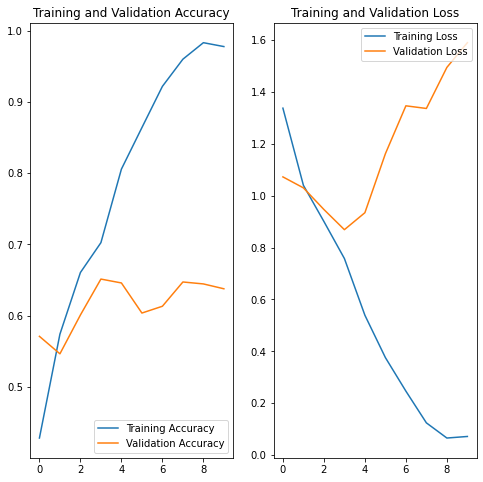

In [223]:
# 4. evaluate
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()